# SWMAL Exercise

## Pipelines

We now try building af ML pipeline. The data for this exercise is the same as in L01, meaning that the OECD data from the 'intro.ipynb' have been save into a Python 'pickle' file. 

The pickle library is a nifty data preservation method in Python, and from L01 the tuple `(X, y)` have been stored to the pickle file `itmal_l01_data.pkl', try reloading it..

In [113]:
%matplotlib inline

import sys
import pickle
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def LoadDataFromL01():
    filename = "Data/itmal_l01_data.pkl"
    with open(f"{filename}", "rb") as f:
        (X, y) = pickle.load(f)
        return X, y

X, y = LoadDataFromL01()

print(f"X.shape={X.shape},  y.shape={y.shape}")

assert X.shape[0] == y.shape[0]
assert X.ndim == 2
assert y.ndim == 1  # did a y.ravel() before saving to picke file
assert X.shape[0] == 29

# re-create plot data (not stored in the Pickel file)
m = np.linspace(0, 60000, 1000)
M = np.empty([m.shape[0], 1])
M[:, 0] = m

print("OK")

X.shape=(29, 1),  y.shape=(29,)
OK


###  Revisiting the problem with the MLP

Using the MLP for the QECD data in Qd) from `intro.ipynb` produced a negative $R^2$, meaning that it was unable to fit the data, and the MPL model was actually _worse_ than the naive $\hat y$ (mean value of y).

Let's just revisit this fact. When running the next cell you should now see an OK $~R^2_{lin.reg}~$ score and a negative $~R^2_{mlp}~$ score..

The MLP may mis-fit the data, seen in the, sometimes, bad R^2 score..

lin.reg.score(X, y)=0.73
    MLP.score(X, y)=-59467.16


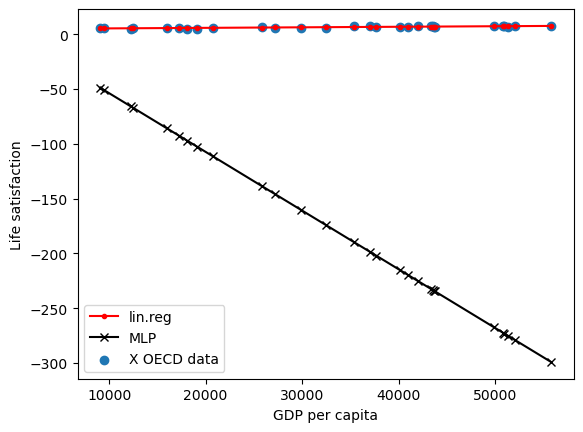


OK


In [114]:
# Setup the MLP and lin. regression again..

def isNumpyData(t: np.ndarray, expected_ndim: int):
    assert isinstance(expected_ndim, int), f"input parameter 'expected_ndim' is not an integer but a '{type(expected_ndim)}'"
    assert expected_ndim>=0, f"expected input parameter 'expected_ndim' to be >=0, got {expected_ndim}"
    if t is None:
        print("input parameter 't' is None", file=sys.stderr)
        return False
    if not isinstance(t, np.ndarray):
        print("excepted numpy.ndarray got type '{type(t)}'", file=sys.stderr)
        return False
    if not t.ndim==expected_ndim:
        print("expected ndim={expected_ndim} but found {t.ndim}", file=sys.stderr)
        return False
    return True

def PlotModels(model1, model2, X: np.ndarray, y: np.ndarray, name_model1: str, name_model2: str):
    
    # NOTE: local function is such a nifty feature of Python!
    def CalcPredAndScore(model, X: np.ndarray, y: np.ndarray,):
        assert isNumpyData(X, 2) and isNumpyData(y, 1) and X.shape[0]==y.shape[0]
        y_pred_model = model.predict(X)
        score_model = r2_score(y, y_pred_model) # call r2
        return y_pred_model, score_model    

    assert isinstance(name_model1, str) and isinstance(name_model2, str)

    y_pred_model1, score_model1 = CalcPredAndScore(model1, X, y)
    y_pred_model2, score_model2 = CalcPredAndScore(model2, X, y)

    plt.plot(X, y_pred_model1, "r.-")
    plt.plot(X, y_pred_model2, "kx-")
    plt.scatter(X, y)
    plt.xlabel("GDP per capita")
    plt.ylabel("Life satisfaction")
    plt.legend([name_model1, name_model2, "X OECD data"])

    l = max(len(name_model1), len(name_model2))
    
    print(f"{(name_model1).rjust(l)}.score(X, y)={score_model1:0.2f}")
    print(f"{(name_model2).rjust(l)}.score(X, y)={score_model2:0.2f}")

# lets make a linear and MLP regressor and redo the plots
mlp = MLPRegressor(hidden_layer_sizes=(10, ),
                   solver='adam',
                   activation='relu',
                   tol=1E-5,
                   max_iter=100000,
                   verbose=False)
linreg = LinearRegression()

mlp.fit(X, y)
linreg.fit(X, y)

print("The MLP may mis-fit the data, seen in the, sometimes, bad R^2 score..\n")
PlotModels(linreg, mlp, X, y, "lin.reg", "MLP")
plt.show()
print("\nOK")

### Qa) Create a Min/max scaler for the MLP

To scale we take the max and min value of X and y. The range is also stored.

Then we simply subtract the min value from the matrix/vector and then divide by the range.

This also needs to be done for the plot data and the predictions.

This gives a way better score than previously.

lin.reg.score(X, y)=0.73
    MLP.score(X, y)=-59467.16


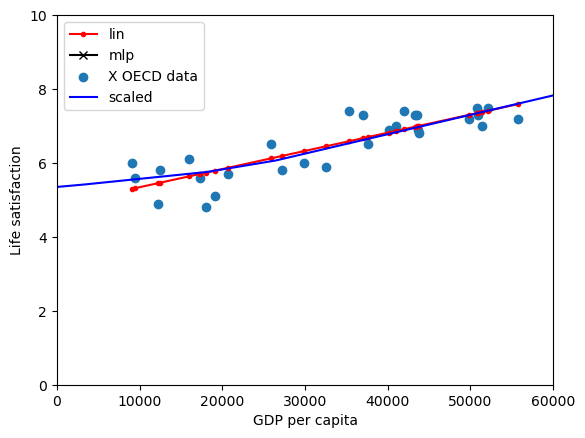

Prediction for GDP=22587: 5.921
Scaled MLP R^2 score=0.7415349284841477


In [115]:
# TODO: add your code here..
from sklearn.neural_network import MLPRegressor

# Manual scaling of X and y to [0,1] range
X_min = np.min(X)
X_max = np.max(X)
X_range = X_max - X_min

y_min = np.min(y)
y_max = np.max(y)
y_range = y_max - y_min

# Scale the training data
X_scaled_manual = (X - X_min) / X_range
y_scaled_manual = (y - y_min) / y_range

# Setup and train MLPRegressor on scaled data
mlpScaled = MLPRegressor(hidden_layer_sizes=(10,), solver='adam', activation='relu', tol=1E-5, max_iter=100000, verbose=False)
mlpScaled.fit(X_scaled_manual, y_scaled_manual.ravel())

# Generate predictions for plotting (scaled MLP)
m_scaled_manual = (m - X_min) / X_range
y_pred_mlp_scaled = mlpScaled.predict(m_scaled_manual.reshape(-1, 1))
y_pred_mlp = y_pred_mlp_scaled * y_range + y_min

PlotModels(linreg, mlp, X, y, "lin.reg", "MLP")
plt.axis([0, 60000, 0, 10])
plt.plot(m, y_pred_mlp, "b")
plt.legend(["lin", "mlp", "X OECD data", "scaled"])
plt.show()

# Test prediction for a new value (Cyprus example)
x_new = 22587
x_new_scaled_manual = (x_new - X_min) / X_range
y_pred_scaled_manual = mlpScaled.predict([[x_new_scaled_manual]])
y_pred_manual = y_pred_scaled_manual * y_range + y_min
print(f"Prediction for GDP={x_new}: {y_pred_manual[0]:.3f}")

# Score
score = mlpScaled.score(X_scaled_manual, y_scaled_manual)
print(f"Scaled MLP R^2 score={score}")

### Qb) Scikit-learn Pipelines

Here we have made a pipeline for linear regressor and MLP simply to compare the two.

It is way simpler to do this compared to before, since the scaling is done in the pipeline. When predicting we dont have to scale manually, it just works.

However we can see that the MLP does not perform any better than the linear regressor(at least not with MinMaxScaling).

Prediction(mlp) for GDP=22587: [5.89062959]
Prediction(lin) for GDP=22587: [5.96242338]
R^2(mlp) score: 0.725249760398055
R^2(lin) score: 0.734441435543703
lin.score(X, y)=0.73
MLP.score(X, y)=0.73


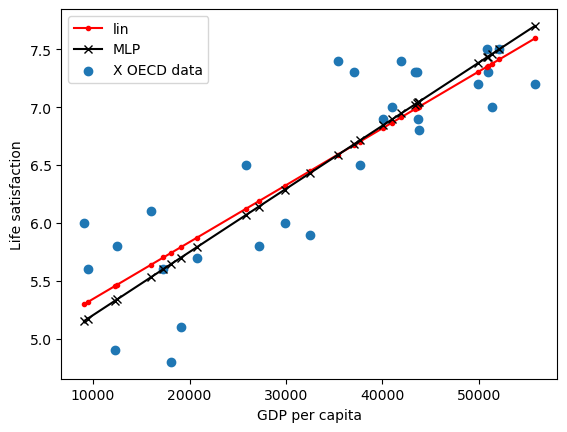

In [116]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

mlp_pipeline = Pipeline([
    ("scaler", MinMaxScaler(feature_range=(0, 1))),
    ("mlp", MLPRegressor(
        hidden_layer_sizes=(10,),
        solver='adam',
        activation='relu',
        tol=1E-5,
        max_iter=100000,
        verbose=False
    ))
])

lin_pipeline = Pipeline([
    ("scaler", MinMaxScaler(feature_range=(0, 1))),
    ("lin", LinearRegression())
])

# Fit model
mlp_pipeline.fit(X, y)
lin_pipeline.fit(X, y)

y_pred = mlp_pipeline.predict(X)
y_lin_pred = lin_pipeline.predict(X)

# Example prediction for Cyprus
x_new = [[22587]]
print("Prediction(mlp) for GDP=22587:", mlp_pipeline.predict(x_new))
print("Prediction(lin) for GDP=22587:", lin_pipeline.predict(x_new))

# Score
print("R^2(mlp) score:", mlp_pipeline.score(X, y))
print("R^2(lin) score:", lin_pipeline.score(X, y))

PlotModels(lin_pipeline, mlp_pipeline, X, y, "lin", "MLP")
plt.show()


### Qc) Outliers and the Min-max Scaler vs. the Standard Scaler

#### MinMaxProblem

The problem with the MinMaxScaler is that a single outlier has a major affect on the rest of the dataset.

Imagine we have these five values: [2, 4, 3, 6, 21]

21 is a clear outlier and it shrink the other values:

MinMaxScaled = 

(2 - 2) / 19 = 0.000

(4 - 2) / 19 = 0.105

(3 - 2) / 19 = 0.053

(6 - 2) / 19 = 0.211

(21 - 2) / 19 = 1.000

#### StandardScaler

The standard scaler converts the values into a mean(likely 0) and then a variance/standard deviation.
This approach ensures that a few outliers do not skew the entire dataset. It should be used when outliers are present, but cant or wont be removed from the set.

As seen on the plot, the MLP is no longer linear and the score has increased slightly.

Prediction(mlp) for GDP=22587: [5.76281057]
Prediction(lin) for GDP=22587: [5.96242338]
R^2(mlp) score: 0.7657274270782745
R^2(lin) score: 0.734441435543703
lin.score(X, y)=0.73
MLP.score(X, y)=0.77


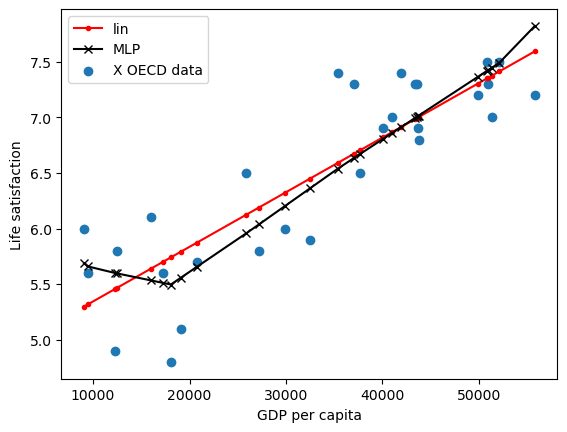

In [117]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

mlp_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPRegressor(
        hidden_layer_sizes=(10,),
        solver='adam',
        activation='relu',
        tol=1E-5,
        max_iter=100000,
        verbose=False
    ))
])

lin_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("lin", LinearRegression())
])

# Fit model
mlp_pipeline.fit(X, y)
lin_pipeline.fit(X, y)

y_pred = mlp_pipeline.predict(X)
y_lin_pred = lin_pipeline.predict(X)

# Example prediction for Cyprus
x_new = [[22587]]
print("Prediction(mlp) for GDP=22587:", mlp_pipeline.predict(x_new))
print("Prediction(lin) for GDP=22587:", lin_pipeline.predict(x_new))

# Score
print("R^2(mlp) score:", mlp_pipeline.score(X, y))
print("R^2(lin) score:", lin_pipeline.score(X, y))

PlotModels(lin_pipeline, mlp_pipeline, X, y, "lin", "MLP")
plt.show()

### Qd) Modify the MLP Hyperparameters

Attempt 1: 1 and 10000 hidden layer sizes: With a single hidden layer and a single neuron, it guesses the mean, which isnt too surprising. With 10000 neurons in 1 layer, it overfits and fits the data using a parabola, which is very wrong.

![1 vs 10000 neurons comparison](figs/1and10k.png)

Attempt 2: 5 and 5, relu and tanh: The tanh is slightly curved and the relu is just straight. The scores are similar. 

![5 neurons with different activations](figs/5and5.png)

Attempt 3: 10 and 10, adam and sgd: The adam solver has a hockey stick like shape and a slightly better score.

![Adam vs SGD solver comparison](figs/10adamandsgd.png)

In general its very difficult to manually find the best hyperparameters, and we therefore rely on machines to try many different combination and then we can decide.

Prediction(MLP_10_adam) for GDP=22587: [5.74367799]
Prediction(MLP_10_sgd) for GDP=22587: [5.75890038]
R^2(MLP_10_adam) score: 0.7585761427469877
R^2(MLP_10_sgd) score: 0.7344704276586562
 MLP_10_sgd.score(X, y)=0.73
MLP_10_adam.score(X, y)=0.76


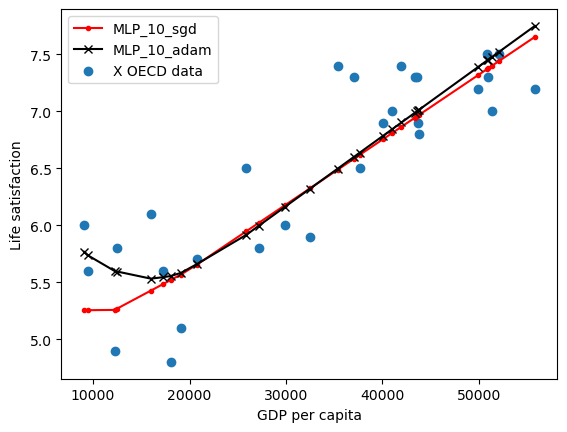

In [118]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

mlp_10_adam = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPRegressor(
        hidden_layer_sizes=(10,),
        solver='adam',
        activation='relu',
        tol=1E-5,
        max_iter=100000,
        verbose=False
    ))
])

mlp_10_sgd = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPRegressor(
        hidden_layer_sizes=(10,),
        solver='sgd',
        activation='relu',
        tol=1E-5,
        max_iter=100000,
        verbose=False
    ))
])

# Fit model
mlp_10_adam.fit(X, y)
mlp_10_sgd.fit(X, y)

y_pred_100 = mlp_10_adam.predict(X)
y_pred_10 = mlp_10_sgd.predict(X)

# Example prediction for Cyprus
x_new = [[22587]]
print("Prediction(MLP_10_adam) for GDP=22587:", mlp_10_adam.predict(x_new))
print("Prediction(MLP_10_sgd) for GDP=22587:", mlp_10_sgd.predict(x_new))

# Score
print("R^2(MLP_10_adam) score:", mlp_10_adam.score(X, y))
print("R^2(MLP_10_sgd) score:", mlp_10_sgd.score(X, y))

PlotModels(mlp_10_sgd, mlp_10_adam, X, y, "MLP_10_sgd", "MLP_10_adam")
plt.show()

REVISIONS||
:-|:-|
2020-10-15| CEF, initial. 
2020-10-21| CEF, added Standard Scaler Q.
2020-11-17| CEF, removed orhpant text in Qa (moded to Qc).
2021-02-10| CEF, updated for ITMAL F21.
2021-11-08| CEF, updated print info.
2021-02-10| CEF, updated for SWMAL F22.
2023-02-19| CEF, updated for SWMAL F23, adjuste page numbers for 3rd.ed.
2023-02-21| CEF, added types, rewrote CalcPredAndScore and added isNumpyData.
2024-09-11| CEF, updated page refefences.